# Trabalho Integrado - Quantum Finance (Computer Vision)

## Integrantes - 5DTS

Integrantes 5DTS

- Ana Paula Lavieri: RM347975
- Eduardo Previero: RM348373
- Fernando Vieceli Costa: RM347957
- Filipe Francelino: RM348328

## Objetivo

O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal. No entanto, os protocolos de segurança da senha foram realizados em conformidade, cada cliente autenticou com sua própria senha.​ Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo similar.​
Além da senha, podemos implementar formas de autenticação complementares, a depender do serviço, que utilizasse uma verificação e identificação facial. Caso o cliente não seja autenticado, ele será atendido por uma esteira dedicada e as evidências da não identificação serão encaminhadas para a área de IA para validação dos parâmetros e limiares para aperfeiçoamento do modelo.
Será necessário construir:​
- Detector de faces​
- Identificação de faces​
- Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.

## Bibliotecas

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import dlib

from os import listdir, path, makedirs
from os.path import isfile, join

## Preparação dos dados

Nesta seção, estamos efetuando a leitura das fotos escolhidas pelos participantes e efetuando a extração das faces para gerar nosso set de dados.

As imagens são lidas da pasta "image-original", e as faces extraídas são armazenadas  na pasta "image-faces", utilizando o mesmo nome do arquivo acrescidos com um prefixo indicando o id da face encontrada na foto.

Para a identificação e recorte das faces, estamos usando o modelo haarcascade.

In [2]:
# Carregar o classificador de faces
classifier_cascade = cv2.CascadeClassifier("models-classifier/haarcascade_frontalface_default.xml")

# Caminho para a pasta com as imagens originais e para a pasta de destino das faces
original_images_path = "image-original"
faces_images_path = "image-faces"

# Criar a pasta de destino se ela não existir
if not os.path.exists(faces_images_path):
    os.makedirs(faces_images_path)

# Percorrer todas as imagens na pasta original
for image_file in os.listdir(original_images_path):
    # Carregar a imagem
    image_path = os.path.join(original_images_path, image_file)
    image_original = cv2.imread(image_path)
    if image_original is None:
        continue  # Pular arquivos que não são imagens

    # Converter a imagem para escala de cinza
    image_gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)

    # Detectar faces na imagem
    faces = classifier_cascade.detectMultiScale(image_gray, 1.3, 5)
    if len(faces) == 0:
        print(f"No face detected in image {image_file}")
        continue

    # Salvar cada face detectada
    for i, (x, y, w, h) in enumerate(faces):
        face_image = image_original[y:y + h, x:x + w]
        face_image_path = os.path.join(faces_images_path, f"face_{i}_{image_file}")
        cv2.imwrite(face_image_path, face_image)
        print(f"Extracted face saved in  {face_image_path}")

## Preparação dos dados

Após a extração das faces, fizemos a reclassificação manual de cada uma, identificando o usuário dono da face.

Para interligar o id do usuário com a face contida na imagem, utilizamos uma nomenclatura no nome arquivo onde os 3 primeiros caracteres são compostos por "s" mais o id número do usuário.

As imagens de treino foram armazenadas no diretório "image-faces-train", enquanto as imagens de testes foram armazenadas em "image-faces-test".

### Carregamento e padronização de imagens (faces)

In [3]:
# Função para padronizar imagem
def padronize_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Error loading file: {image_path}")    
    image = cv2.resize(image, (200, 200), interpolation=cv2.INTER_LANCZOS4)
    return image

In [4]:
# Leitura dos dados para treino e teste
faces_path_train = "image-faces-train/"
faces_path_test = "image-faces-test/"
# list_original_face_train = [f for f in listdir(faces_path_train) if isfile(join(faces_path_train, f))]
# list_original_face_test = [f for f in listdir(faces_path_test) if isfile(join(faces_path_test, f))]
list_original_face_train = [arq for arq in os.listdir(faces_path_train) if arq.lower().endswith(('.png', '.jpg', '.jpeg'))]
list_original_face_test = [arq for arq in os.listdir(faces_path_test) if arq.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Preparando set de dados para treino e teste
list_face_train, list_id_train = [], [] 
list_face_test, list_id_test = [], [] 

# Prepara lista de treino e testes - Nome dos arquivos devem estar no padrão "sXX_*", onde XX é o Id da pessoa 
for i, arq in enumerate(list_original_face_train):
    image_path = faces_path_train + arq
    image = padronize_image(image_path)
    list_face_train.append(image)
    person_id = arq[1:3]
    list_id_train.append(int(person_id))    
    
for i, arq in enumerate(list_original_face_test):
    image_path = faces_path_test + arq
    image = padronize_image(image_path)
    list_face_test.append(image)
    person_id = arq[1:3]
    list_id_test.append(int(person_id))    

# Rápida verificação dos dados de treino e teste
print("Train: ", len(list_face_train), " & ",len(list_id_train))
print("Test: ", len(list_face_test), " & ",len(list_id_test))

Train:  39  &  39
Test:  15  &  15


### Validação e verificação de imagens carregadas

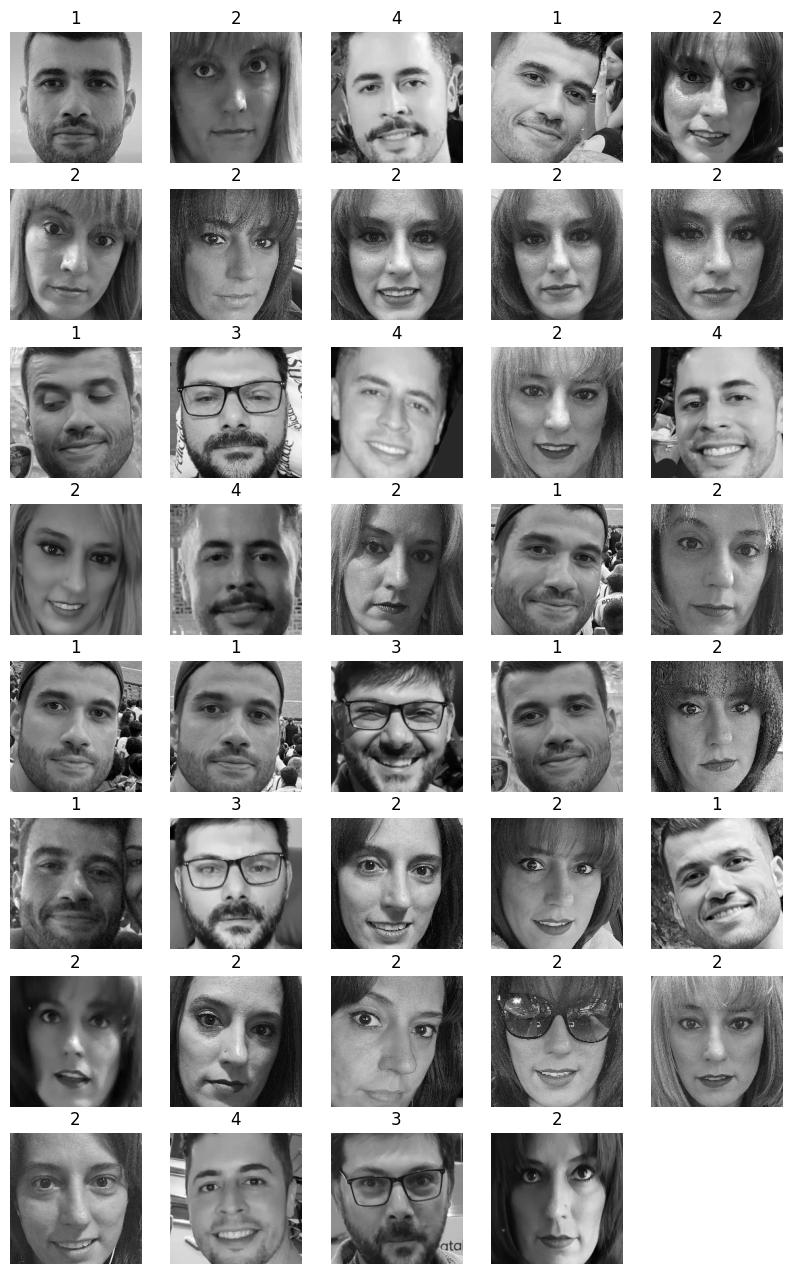

Total faces (train): 39



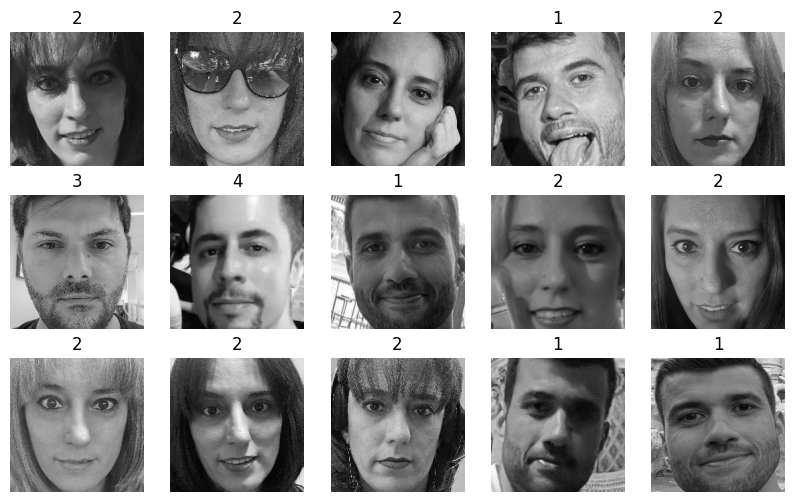

Total faces (test): 15



In [5]:
photo_size = (2, 2)
faces_per_row = 5

# Impressão de todas as fotos de treino
face_count = len(list_face_train)
rows = (face_count - 1) // faces_per_row + 1
plt.figure(figsize=(photo_size[0] * faces_per_row, photo_size[1] * rows))
for i in range(face_count):
    plt.subplot(rows, faces_per_row, i + 1)
    plt.title(list_id_train[i])
    plt.imshow(list_face_train[i], cmap='gray')
    plt.axis('off')
plt.show()
print(f"Total faces (train): {face_count}\n")

# Impressão de todas as fotos de teste
face_count = len(list_face_test)
rows = (face_count - 1) // faces_per_row + 1
plt.figure(figsize=(photo_size[0] * faces_per_row, photo_size[1] * rows))
for i in range(face_count):
    plt.subplot(rows, faces_per_row, i + 1)
    plt.title(list_id_test[i])
    plt.imshow(list_face_test[i], cmap='gray')
    plt.axis('off')
plt.show()
print(f"Total faces (test): {face_count}\n")

### Criação de Lista com nomes por Id 

In [6]:
# Dicionário com ID e nome da pessoa
persons_id = {
    1: "Fernando Costa",
    2: "Ana Lavieri",
    3: "Eduardo Previero",
    4: "Filipe Francelino"
}

## Treinamento

Para o treinamento, utilizamos três modelos como base: Eingenfaces, Fisherfaces e LBPH.

Todos os modelos serão treinados com os mesmos dados, e o que apresentar melhor performance (acurácia) será utilizado em nosso sistema de reconhecimento.

### Treinamento - Modelo Eingenfaces

In [7]:
# Treinamento do modelo eingenfaces
labels_id_train = np.array(list_id_train, dtype=np.int32)
model_eingenfaces = cv2.face.EigenFaceRecognizer_create()
model_eingenfaces.train(list_face_train, labels_id_train)

In [8]:
# Teste de acurácia
list_label_pred = []
labels_id_test = np.array(list_id_test, dtype=np.int32)
for i in list_id_test:
    label, _ = model_eingenfaces.predict(list_face_test[i])
    list_label_pred.append(label)
acuracy = accuracy_score(labels_id_test, list_label_pred)
print("Acurácia: ", acuracy)

Acurácia:  0.6


### Treinamento - Fisherfaces

In [9]:
# Treinamento do modelo fisherfaces
labels_id_train = np.array(list_id_train, dtype=np.int32)
model_fisherfaces = cv2.face.FisherFaceRecognizer_create()
model_fisherfaces.train(list_face_train, labels_id_train)

In [10]:
# Teste de acurácia
list_label_pred = []
labels_id_test = np.array(list_id_test, dtype=np.int32)
for i in list_id_test:
    label, _ = model_fisherfaces.predict(list_face_test[i])
    list_label_pred.append(label)
acuracy = accuracy_score(labels_id_test, list_label_pred)
print("Acurácia: ", acuracy)

Acurácia:  0.6


### Treinamento - Modelo LBPH 

In [11]:
# Treinamento do modelo LBPH
labels_id_train = np.array(list_id_train, dtype=np.int32)
model_lbph = cv2.face.LBPHFaceRecognizer_create()
model_lbph.train(list_face_train, labels_id_train)

In [12]:
# Teste de acurácia
list_label_pred = []
labels_id_test = np.array(list_id_test, dtype=np.int32)
for i in list_id_test:
    label, _ = model_lbph.predict(list_face_test[i])
    list_label_pred.append(label)
acuracy = accuracy_score(labels_id_test, list_label_pred)
print("Acurácia: ", acuracy)

Acurácia:  0.6


## Reconhecimento de faces

### Reconhecimento de face com captura de imagem estática

Nesta seção, utilizaremos

In [13]:
# Função para captura da imagem
def capture_image():
    global frame
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Erro: Não foi possível abrir a webcam.")
        return None
    while True:
        ret, frame = cap.read()
        if ret:
            cv2.imshow('Webcam', frame)
            if cv2.waitKey(1) & 0xFF == 13:  # Enter
                break
        else:
            print("Erro: Não foi possível capturar um frame da webcam.")
            return None
    cap.release()
    cv2.destroyAllWindows()
    return frame

2024-04-14 21:06:43.946 Python[8410:22092658] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


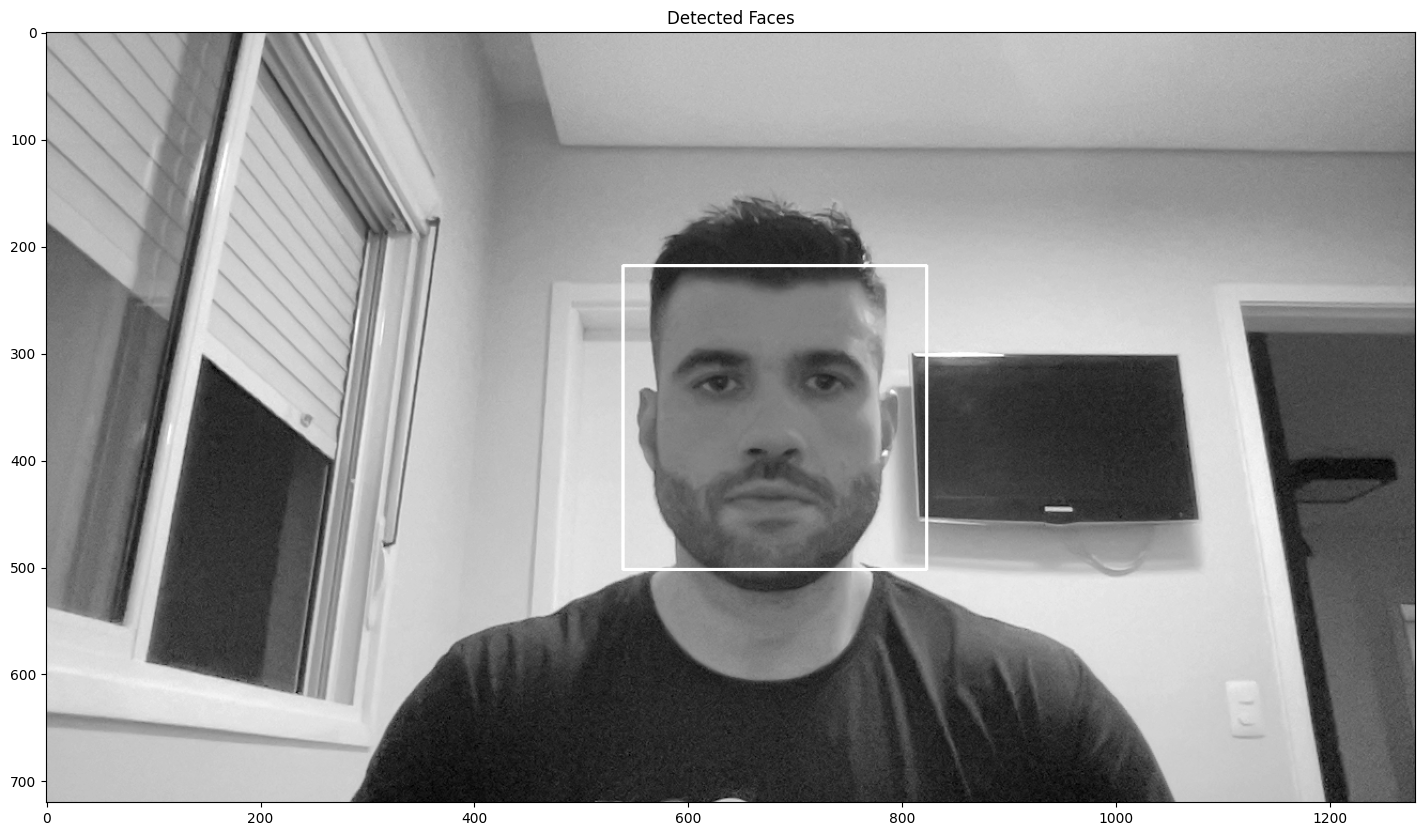

In [14]:
# Aciona camera e armazena fotos em 3 padrões de cores
image_original = capture_image()
image_color    = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
image_gray     = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)

# Cria classificador de faces
classifier_cascade = cv2.CascadeClassifier("models-classifier/haarcascade_frontalface_default.xml")

# Extrai faces da foto capturada
faces = classifier_cascade.detectMultiScale(image_gray, 1.3, 5)
image_detected_faces = image_gray.copy()

# Traça retangulos nas faces detectadas
for (x,y,w,h) in faces:
    cv2.rectangle(image_detected_faces, (x,y), (x+w, y+h), (255, 255, 0), 2)
plt.figure(figsize=(20,10))
plt.title("Detected Faces")
plt.imshow(image_detected_faces, cmap='gray')


Resultados para Face 0
Modelo Eingenfaces:  (1, 5640.617891894658)  -  Fernando Costa
Modelo Fisherfaces:  (1, 361.55998536489267)  -  Fernando Costa
Modelo LBPH:  (1, 61.46334162529131)  -  Fernando Costa


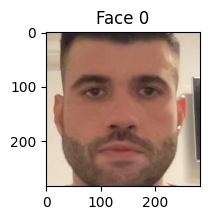

In [15]:
# Percorre faces detectadas
for i, (x, y, w, h) in enumerate(faces):
        
    face_color = image_color[y:y + h, x:x + w]       
    face_gray  = image_gray[y:y + h, x:x + w]
    face_image_std = cv2.resize(face_gray, (200, 200), interpolation=cv2.INTER_LANCZOS4)

    # Imprime face detectada
    plt.figure(figsize=(2, 2))
    plt.title(f"Face {i}")
    plt.imshow(face_color)

    # Imprime face detectada por cada modelo
    print(f"\nResultados para Face {i}")
    predict_face = model_eingenfaces.predict(face_image_std)
    predict_name = persons_id.get(predict_face[0], "Unknow")
    print("Modelo Eingenfaces: ", predict_face, " - ", predict_name)
    predict_face = model_fisherfaces.predict(face_image_std)
    predict_name = persons_id.get(predict_face[0], "Unknow")
    print("Modelo Fisherfaces: ", predict_face, " - ", predict_name)
    predict_face = model_lbph.predict(face_image_std)
    predict_name = persons_id.get(predict_face[0], "Unknow")
    print("Modelo LBPH: ", predict_face, " - ", predict_name)

### Reconhecimento de face com captura de imagem em tempo real (Sem Liveness)

In [16]:
# Cria classificador de faces
classifier_cascade = cv2.CascadeClassifier("models-classifier/haarcascade_frontalface_default.xml")

# Definir um limite de confiança para detecção
# threshold_face_confidence = 6000
threshold_face_confidence = 60

# Função para detectar faces e exibir na imagem em tempo real
def detect_and_display_faces(frame):
    
    # Converte para escala de cinza
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = classifier_cascade.detectMultiScale(frame_gray, 1.3, 5)

    # Percorre as faces detectadas
    for (x, y, w, h) in faces:

        # Desenha um retângulo ao redor da face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extrai a região da face e faz a previsão do usuário
        face_gray = frame_gray[y:y + h, x:x + w]
        face_gray_resized = cv2.resize(face_gray, (200, 200), interpolation=cv2.INTER_LANCZOS4)
        # predict_face, predict_confidence = model_eingenfaces.predict(face_gray_resized)
        predict_face, predict_confidence = model_lbph.predict(face_gray_resized)
        
        # Caso o grau de confiança seja menor que o threshold, imprime o nome na tela
        if predict_confidence < threshold_face_confidence:
            predict_name = persons_id.get(predict_face, "Unknown")
            cv2.putText(frame, predict_name, (x, y + h + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            # print("Predicted: ", predict_face, " - ", predict_name, " - Confidence: ", predict_confidence)            

    # Exibe o frame com as faces detectadas
    cv2.imshow('Webcam', frame)

In [17]:
# Inicia a captura de imagem pela câmera
video_cap = cv2.VideoCapture(0)
if not video_cap.isOpened():
    print("Error opening webcam.")
while True:
    ret, frame = video_cap.read()
    if ret:
        detect_and_display_faces(frame)
        if cv2.waitKey(1) & 0xFF == 27:  # Aguarda tecla "Esc" para sair
            break
    else:
        print("Error capturing video frame.")
        break

# Finaliza processo e fecha câmera
video_cap.release()
cv2.destroyAllWindows()

### Reconhecimento de face com captura de imagem em tempo real (Com Liveness)

In [20]:
# Threshold para lógicas de detecção face, fechamento de olhos e número de piscadas para inicio da idenficiação de pessoas
# threshold_face_confidence = 6000
threshold_face_confidence = 60
threshold_ratio_eye_open  = 0.3
threshold_ratio_eye_closed = 0.2
threshold_blinks = 3

# Inicializa variaveis de controle
flag_eye_open = True
flag_eye_closed = False
counter_blinks = 0

# Modelos classificadores de faces e de marcos faciais
model_classifier_cascade    = cv2.CascadeClassifier("models-classifier/haarcascade_frontalface_default.xml")
model_classifier_dlib       = dlib.shape_predictor("models-classifier/shape_predictor_68_face_landmarks.dat")

# Função para calcular aspect ratio para os olhos
def eye_aspect_ratio(eye):

    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Função para detectar faces e exibir na imagem em tempo real
def detect_and_display_faces(frame):

    global flag_eye_open, flag_eye_closed, counter_blinks

    # Converte frame para escala de cinza e detecta faces
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = model_classifier_cascade.detectMultiScale(frame_gray, 1.3, 5)

    # Percorre as faces detectadas
    for (x, y, w, h) in faces:
 
        # Busca por marcos faciais na região detectada
        rectangle_dlib = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
        predict_shape = model_classifier_dlib(frame_gray, rectangle_dlib)
        predict_shape_np = np.array([(p.x, p.y) for p in predict_shape.parts()], dtype="int")

        # Desenha os pontos faciais na face detectada
        for n in range(0, 68):
            point = predict_shape.part(n)
            cv2.circle(frame, (point.x, point.y), 2, (0, 255, 0), -1)

        # Extrai coordenada dos olhos e orelhas
        predict_shape_eye_left  = predict_shape_np[42:48]
        predict_shape_eye_right = predict_shape_np[36:42]
        predict_shape_ear_left  = eye_aspect_ratio(predict_shape_eye_left)
        predict_shape_ear_right = eye_aspect_ratio(predict_shape_eye_right)
        ratio_shape_eye = (predict_shape_ear_left + predict_shape_ear_right) / 2.0

        # Aplica thresholds para descobrir se o usuário piscou os olhos
        if ratio_shape_eye < threshold_ratio_eye_closed:
            if flag_eye_open:
                flag_eye_closed = True
                flag_eye_open = False
        elif ratio_shape_eye > threshold_ratio_eye_open:
            if flag_eye_closed:                
                flag_eye_open = True
                flag_eye_closed = False
                counter_blinks += 1
                # print("Detected blinks: ", counter_blinks)

        # Verifica se o usuário efetuou as piscadas suficientes para atestar a vivacidade
        if counter_blinks > threshold_blinks:
            
            # Padroniza imagem para classificação
            face_gray = frame_gray[y:y + h, x:x + w]
            face_gray_resized = cv2.resize(face_gray, (200, 200), interpolation=cv2.INTER_LANCZOS4)
            # predict_face, predict_confidence = model_eingenfaces.predict(face_gray_resized)
            predict_face, predict_confidence = model_lbph.predict(face_gray_resized)            
            # print("Model Prediction: ", predict_face, " - ", predict_confidence)

            # Caso a distância do rosto para o usuário identificado seja menor que o threshold, imprime o nome na tela
            if predict_confidence < threshold_face_confidence:
                predict_name = persons_id.get(predict_face, "Unknown")
                detected_user_text = f"Pessoa identificada: {predict_name}"
                cv2.putText(frame, detected_user_text, (10, frame.shape[0] - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                # print("Predicted Person: ", predict_face, " - ", predict_name)

    # Adiciona texto de instrução na tela
    cv2.putText(frame, "Por favor, posicione seu rosto no centro da camera e pisque os olhos pausadamente por algumas vezes!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    # Exibe o frame com as faces detectadas
    cv2.imshow('Webcam', frame)

In [21]:
# Inicia a captura de imagem pela câmera
video_cap = cv2.VideoCapture(0)
if not video_cap.isOpened():
    print("Error opening webcam.")
while True:
    ret, frame = video_cap.read()
    if ret:
        detect_and_display_faces(frame)
        if cv2.waitKey(1) & 0xFF == 27:  # Aguarda tecla "Esc" para sair
            break
    else:
        print("Error capturing video frame.")
        break

# Finaliza processo e fecha câmera
video_cap.release()
cv2.destroyAllWindows()